In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

In [4]:
df_cct = pd.read_parquet("/home/onyxia/work/df_all.parquet")

/tmp/ipykernel_18869/1342149493.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cct.corr())


<Axes: >

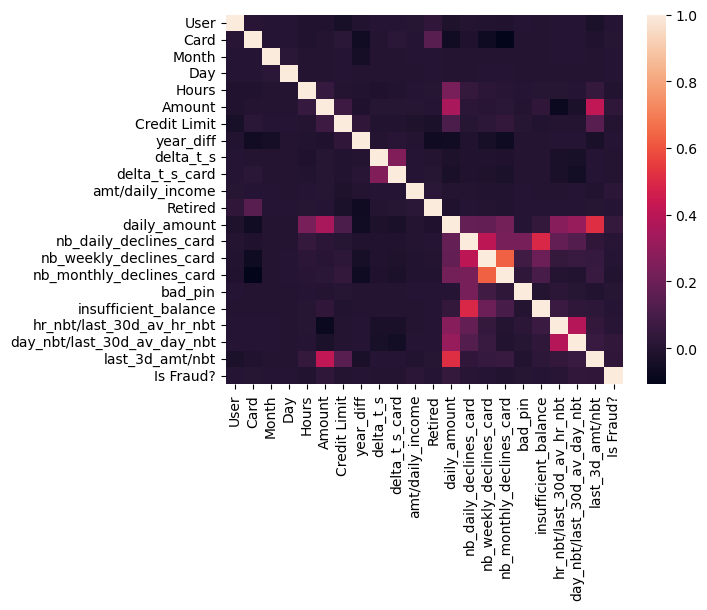

In [5]:
sns.heatmap(df_cct.corr())

In [ ]:
# selecting features
features = ['Card', 'Month', 'Day', 'Hours', 'Amount', 'Use Chip',
       'Card Brand', 'Card Type', 'Credit Limit', 'year_diff', 'delta_t_s',
       'delta_t_s_card', 'day_of_week', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt']
X = df_cct[features]
y = df_cct["Is Fraud?"]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# using Column Transformer for RobustScaler (numerical values) and OneHotEncoder (categorical values)
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('rbscaler', RobustScaler(), ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'Credit Limit', 'year_diff',
       'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'daily_amount',
       'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt']),
       ('oe', OneHotEncoder(handle_unknown="ignore"), ["Card Brand", "Card Type", "day_of_week", "Use Chip"])
        ])
X = preprocessor.fit_transform(X)

In [ ]:
# splitting train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
rforest = RandomForestClassifier(criterion='entropy')
rforest.fit(X_train,y_train)


In [ ]:
# Apply model to validation data
y_pred = rforest.predict(X_test)

In [ ]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred))

In [ ]:
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()

In [ ]:

cnf_matrix_dtree = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()